In [18]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import glob, json
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, localRFM, localSkip, deepSkip, deepRFM, localDeepRFM, localDeepSkip
# import parallel_euler as arch1
import torch, time
from torch import nn
import config
# warnings.filterwarnings('ignore'

dynamical_system = 'KS'
L = 200
# Uo = torch.tensor(np.load(f'../data/{dynamical_system}/train.npy'))[:,:100000]
# Vo = torch.tensor(np.load(f'../data/{dynamical_system}/test.npy'))
Uo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/train.npy'))[:,:100000]
Vo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/test.npy'))
# Uo = torch.tensor(ks0.ks32(dt=0.01, tmax=300)[:, 4000:-1000])
noise =  0.001*torch.randn(size=Uo.shape)
Uon = Uo + noise

L0, L1 = 0.4, 3.5
D, D_r, B = 3, 2048, 1
beta = 1e-5
data_folder = '../data'
G, I = 8, 1                                                                                              

drf_args = [D_r, 1, L0, L1, Uo, beta, 'LocalSkip', f'{data_folder}/temp/localSkipKS/depth-{B}', False, G, I]
b = localRFM.BatchDeepRF(Uo, Vo, *drf_args)
start = time.time()
b.drf.learn(Uo, 42)

bn = localRFM.BatchDeepRF(Uo, Vo, *drf_args)
bn.drf.learn(Uon, 42)
end = time.time()

print(f"Time taken = {end-start}s")
kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
          22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
          12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003},\
         '13_5':{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.059},\
         '200-001':{'error_threshold': 0.25, 'dt': 0.001, 'Lyapunov_time': 1/0.094},}
# kwargs = {'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}
print(b.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())
print(bn.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())

@ut.timer
def get_eval(batch):
    eval = torch.zeros_like(Uo.T)
    j = 0
    for i in range(10):
        eval[j:j+10000] = batch.drf.forecast(Uo.T[j:j+10000])
        j += 10000
    return eval

Time taken = 8.04761004447937s
Time taken by compute_tau_f is 4.2223 seconds
tensor(1.9340)
Time taken by compute_tau_f is 3.9294 seconds
tensor(3.6213)


**Look at loss**

In [20]:
X = Uo.T[:-1][..., b.drf.net.idx][:, b.drf.net.Ng//2, :]
Y = Uo.T[1:][..., b.drf.net.idy][:, b.drf.net.Ng//2, :]

Xn = Uon.T[:-1][..., bn.drf.net.idx][:, bn.drf.net.Ng//2, :]
Yn = Uon.T[1:][..., bn.drf.net.idy][:, bn.drf.net.Ng//2, :]

phi = torch.tanh(b.drf.net.inner[0](X)).detach()
phin = torch.tanh(bn.drf.net.inner[0](Xn)).detach()
phin_ = torch.tanh(bn.drf.net.inner[0](X)).detach()

Yphi = Y.T@phi
Yphin = Yn.T@phin

# eval = torch.tensor(np.load('../data/temp/eval.npy'))
# evaln = torch.tensor(np.load('../data/temp/evaln.npy'))

w = torch.sqrt((b.drf.net.outer[0].weight.detach()**2).sum())
wn = torch.sqrt((bn.drf.net.outer[0].weight.detach()**2).sum())
print(w, wn)

loss = ((b.drf.net.outer[0](phi) - Y)**2).sum() #+ beta*w**2
lossn = ((bn.drf.net.outer[0](phin) - Yn)**2).sum() #+ beta*wn**2
lossn_ = ((bn.drf.net.outer[0](phin_) - Y)**2).sum()
print(loss, lossn, lossn_)

tensor(324.3710) tensor(321.7099)
tensor(1.0056, grad_fn=<SumBackward0>) tensor(2.1951, grad_fn=<SumBackward0>) tensor(1.1223, grad_fn=<SumBackward0>)


**Condition number of the invertible matrix**

In [21]:
a0 = phi.T@phi
a = a0 + beta*torch.eye(D_r)

a0n = phin.T@phin 
an = a0n + beta*torch.eye(D_r)

print(np.linalg.det(a0n), torch.linalg.det(an))



con = torch.linalg.cond(a)
conn = torch.linalg.cond(an)

print(con, conn)

-0.0 tensor(0.)
tensor(1.6519e+13) tensor(1.6507e+13)


In [12]:
torch.linalg.cond(a0), torch.linalg.cond(a0n)

(tensor(2.9779e+19), tensor(6.0197e+18))

(967.3397802885812,
 151.03316097643585,
 2.5691229591189725e+19,
 8.368571339863921e+19,
 2683870.0965896253,
 2016435.220068997)

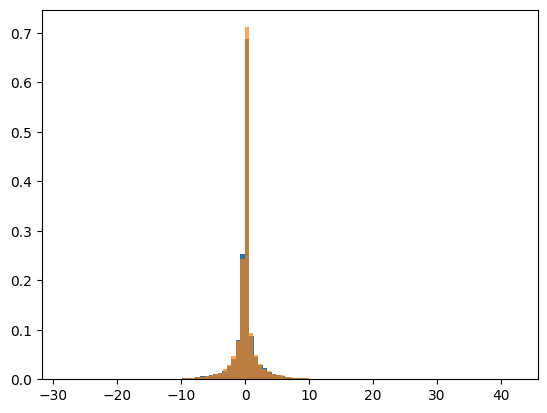

In [22]:
W = b.drf.net.outer[0].weight.detach().numpy()
Wn = bn.drf.net.outer[0].weight.detach().numpy()
plt.hist(W.flatten(), bins=100, density=True)
plt.hist(Wn.flatten(), bins=100, alpha=0.7, density=True)
plt.savefig('../data/plots/W-dist.png')
np.linalg.cond(W), np.linalg.cond(Wn), np.linalg.cond(a0), np.linalg.cond(a0n), np.linalg.cond(Yphi), np.linalg.cond(Yphin)

In [17]:
np.linalg.cond(Y[:1000]), np.linalg.cond(Yn[:1000])

(49392.25000692229, 3435.184497611873)

In [30]:
torch.randn(size=(4, 5), device='cpu')

tensor([[-1.5977,  0.2813,  0.5410, -0.9720,  0.2082],
        [ 0.4914,  1.3892, -0.0283,  0.5568,  0.0534],
        [-0.8907, -0.5449, -0.7132, -0.9826,  0.5637],
        [-0.4679, -0.6799,  0.5859,  0.7179, -1.1606]])